In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [7]:
# Read reviews in german
df = pd.read_csv('../../data/amazon_reviews_multi_DE.csv')
print(df.shape)
df.head()

(210000, 8)


,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,de_0203609,product_de_0865382,reviewer_de_0267719,1,Armband ist leider nach 1 Jahr kaputt gegangen,Leider nach 1 Jahr kaputt,de,sports
1,de_0559494,product_de_0678997,reviewer_de_0783625,1,In der Lieferung war nur Ein Akku!,EINS statt ZWEI Akkus!!!,de,home_improvement
2,de_0238777,product_de_0372235,reviewer_de_0911426,1,"Ein Stern, weil gar keine geht nicht. Es hande...",Achtung Abzocke,de,drugstore
3,de_0477884,product_de_0719501,reviewer_de_0836478,1,"Dachte, das wären einfach etwas festere Binden...",Zu viel des Guten,de,drugstore
4,de_0270868,product_de_0022613,reviewer_de_0736276,1,Meine Kinder haben kaum damit gespielt und nac...,Qualität sehr schlecht,de,toy


## Quick EDA

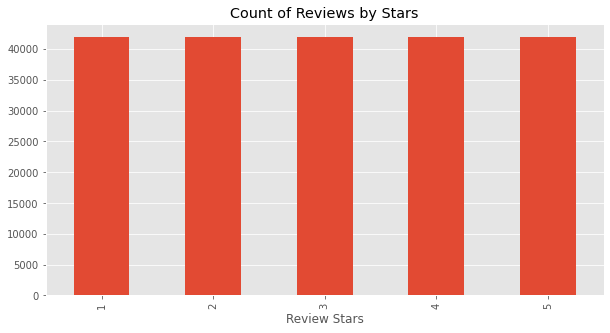

In [8]:
ax = df['stars'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

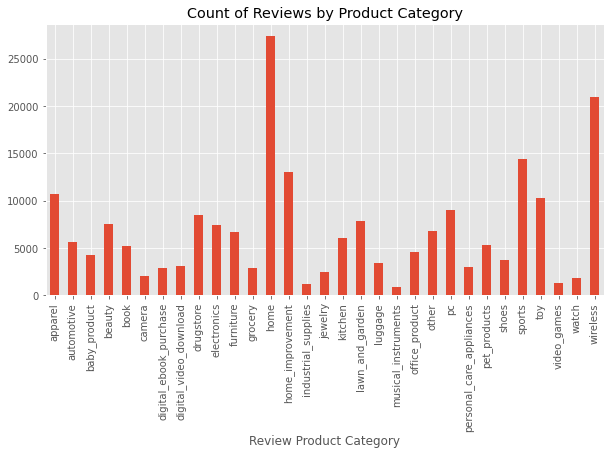

In [10]:
ax = df['product_category'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Product Category',
          figsize=(10, 5))
ax.set_xlabel('Review Product Category')
plt.show()

In [11]:
product_categories = df['product_category'].unique()
print(product_categories)

['sports' 'home_improvement' 'drugstore' 'toy' 'baby_product'
 'lawn_and_garden' 'electronics' 'book' 'home' 'wireless' 'pc' 'shoes'
 'automotive' 'furniture' 'beauty' 'digital_ebook_purchase' 'kitchen'
 'personal_care_appliances' 'office_product' 'apparel' 'video_games'
 'pet_products' 'digital_video_download' 'musical_instruments' 'other'
 'watch' 'luggage' 'jewelry' 'camera' 'industrial_supplies' 'grocery']


## Basic NLTK

In [13]:
example = df['review_body'][50]
print(example)

Ganz schlechte Verarbeitung. Die Schicht blättert ab und benutzen kann ich diese nicht mehr. Leider. Da Kauf ich lieber etwas teureres.


In [23]:
nltk.download('punkt') # Download the punkt tokenizer for german
tokens = nltk.word_tokenize(language="german", text=example)
tokens

[nltk_data] Downloading package punkt to /home/arkimedez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Ganz',
 'schlechte',
 'Verarbeitung',
 '.',
 'Die',
 'Schicht',
 'blättert',
 'ab',
 'und',
 'benutzen',
 'kann',
 'ich',
 'diese',
 'nicht',
 'mehr',
 '.',
 'Leider',
 '.',
 'Da',
 'Kauf',
 'ich',
 'lieber',
 'etwas',
 'teureres',
 '.']

## Step 1. VADER Seniment Scoring

In [37]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


In [40]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/arkimedez/nltk_data...


In [41]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [90]:
from mtranslate import translate
translation = translate(example, "en","de")
print(translation)

Very bad processing. The layer is peeling off and I can no longer use it. Unfortunately. So I'd rather buy something more expensive.


In [91]:
# original
sia.polarity_scores(example)

{'neg': 0.163, 'neu': 0.837, 'pos': 0.0, 'compound': -0.5994}

In [92]:
sia.polarity_scores(translation)

{'neg': 0.306, 'neu': 0.694, 'pos': 0.0, 'compound': -0.8122}

In [102]:
# Run the polarity score on the entire dataset
df = df[:10]
res = {}
for i, row in df.iterrows():
    print(i)
    text = row['review_body']
    id = row['review_id']
    textTranslated = translate(text, "en","de")
    res[id] = sia.polarity_scores(textTranslated)



0
1
2
3
4
5
6
7
8
9


In [103]:
res

{'de_0203609': {'neg': 0.565, 'neu': 0.435, 'pos': 0.0, 'compound': -0.6369},
 'de_0559494': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 'de_0238777': {'neg': 0.051, 'neu': 0.949, 'pos': 0.0, 'compound': -0.4767},
 'de_0477884': {'neg': 0.059, 'neu': 0.615, 'pos': 0.326, 'compound': 0.8893},
 'de_0270868': {'neg': 0.0, 'neu': 0.9, 'pos': 0.1, 'compound': 0.2748},
 'de_0146666': {'neg': 0.034, 'neu': 0.888, 'pos': 0.077, 'compound': 0.4821},
 'de_0846730': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 'de_0833758': {'neg': 0.053, 'neu': 0.855, 'pos': 0.092, 'compound': 0.296},
 'de_0055293': {'neg': 0.208, 'neu': 0.792, 'pos': 0.0, 'compound': -0.6115},
 'de_0232738': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}}

In [110]:
vaders = pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
de_0203609,0.565,0.435,0.000,-0.6369
de_0559494,0.000,1.000,0.000,0.0000
de_0238777,0.051,0.949,0.000,-0.4767
de_0477884,0.059,0.615,0.326,0.8893
de_0270868,0.000,0.900,0.100,0.2748
de_0146666,0.034,0.888,0.077,0.4821
de_0846730,0.000,1.000,0.000,0.0000
de_0833758,0.053,0.855,0.092,0.2960
de_0055293,0.208,0.792,0.000,-0.6115
de_0232738,0.000,1.000,0.000,0.0000


In [111]:
vaders = vaders.reset_index().rename(columns={'index': 'review_id'})
vaders = vaders.merge(df, how='left')

In [112]:
vaders

,review_id,neg,neu,pos,compound,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,de_0203609,0.565,0.435,0.000,-0.6369,product_de_0865382,reviewer_de_0267719,1,Armband ist leider nach 1 Jahr kaputt gegangen,Leider nach 1 Jahr kaputt,de,sports
1,de_0559494,0.000,1.000,0.000,0.0000,product_de_0678997,reviewer_de_0783625,1,In der Lieferung war nur Ein Akku!,EINS statt ZWEI Akkus!!!,de,home_improvement
2,de_0238777,0.051,0.949,0.000,-0.4767,product_de_0372235,reviewer_de_0911426,1,"Ein Stern, weil gar keine geht nicht. Es hande...",Achtung Abzocke,de,drugstore
3,de_0477884,0.059,0.615,0.326,0.8893,product_de_0719501,reviewer_de_0836478,1,"Dachte, das wären einfach etwas festere Binden...",Zu viel des Guten,de,drugstore
4,de_0270868,0.000,0.900,0.100,0.2748,product_de_0022613,reviewer_de_0736276,1,Meine Kinder haben kaum damit gespielt und nac...,Qualität sehr schlecht,de,toy
5,de_0146666,0.034,0.888,0.077,0.4821,product_de_0935874,reviewer_de_0917477,1,"Schmeckt einfach nicht gut, es kostet ziemlich...",Nicht lecker,de,drugstore
6,de_0846730,0.000,1.000,0.000,0.0000,product_de_0400718,reviewer_de_0893909,1,Ich finde das Hase sieht in echt ganz anders a...,Fehlbestellung,de,toy
7,de_0833758,0.053,0.855,0.092,0.2960,product_de_0115194,reviewer_de_0953310,1,"Habe diesen Artikel bestellt,war auf meiner Wu...",Fehlkauf,de,home_improvement
8,de_0055293,0.208,0.792,0.000,-0.6115,product_de_0034085,reviewer_de_0253995,1,Die Lampe ist nach einem Jahr bei nur gelegent...,Nach kurzer Zeit defekt,de,baby_product
9,de_0232738,0.000,1.000,0.000,0.0000,product_de_0901865,reviewer_de_0033281,1,Kaum Saat aufgegangen.,Schlechte Mischung,de,lawn_and_garden


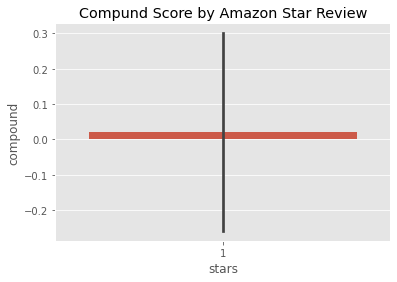

In [114]:
ax = sns.barplot(data=vaders, x='stars', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()